# RAPIDS + Optuna + xfeat: CPU comparison Notebook 

In [2]:
import time
import json
import requests
import logging

import numpy as np

import mlflow
import mlflow.sklearn
from  mlflow.tracking import MlflowClient

from mlflow.models.signature import infer_signature

import optuna
from optuna.integration.mlflow import MLflowCallback
from optuna.study import StudyDirection
from optuna.trial import TrialState
from optuna import type_checking

import xfeat
from xfeat.pipeline import Pipeline
from xfeat.num_encoder import SelectNumerical
from xfeat.selector import ChiSquareKBest
from xfeat.optuna_selector import KBestThresholdExplorer
from functools import partial

from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
import sklearn
import pandas as pd

from sklearn.model_selection import train_test_split
from xfeat.cat_encoder import LabelEncoder, TargetEncoder
from xfeat import ArithmeticCombinations, Pipeline, SelectNumerical

In [3]:
import time
from contextlib import contextmanager
# Helping time blocks of code
@contextmanager
def timed(txt):
    t0 = time.time()
    yield
    t1 = time.time()
    print("%32s time:  %8.5f" % (txt, t1 - t0))

In [4]:
MLFLOW_TRACKING_URI='sqlite:////tmp/mlflow-db.sqlite'
MLFLOW_MODEL_ID = "rapids-optuna-airline"

def get_latest_mlflow_model(tracking_uri, model_id):
    client = MlflowClient(tracking_uri=tracking_uri, registry_uri=tracking_uri)
    model = client.get_registered_model(model_id)
    latest_model = model.latest_versions[0]

    return f"MLFLOW_TRACKING_URI={tracking_uri} mlflow models serve --no-conda -m models:/{model_id}/{latest_model.version} -p 56767"

## Custom callback, for additional flexibility, based on MLflowCallback
class RAPIDSMLflowCallback(object):
    def __init__(self, tracking_uri: str = "sqlite:////tmp/mlflow-db.sqlite",
                 experiment_name: str = "RAPIDS-Optuna",
                 metric_name="value"):
        self._tracking_uri = tracking_uri
        self._experiment_name = experiment_name
        self._metric_name = metric_name
        
    def __call__(self, study, trial):
        if (self._tracking_uri is not None):
            mlflow.set_tracking_uri(self._tracking_uri)
        
        eid = mlflow.set_experiment(self._experiment_name)
        with mlflow.start_run(run_name=f"Trial: {trial.number}", experiment_id=eid, nested=True):
            trial_value = trial.value if trial.value is not None else float("nan")
            mlflow.log_metric(self._metric_name, trial_value)
            
            mlflow.log_params(trial.params)

            tags = {}
            tags["number"] = str(trial.number)
            tags["datetime_start"] = str(trial.datetime_start)
            tags["datetime_complete"] = str(trial.datetime_complete)
            tags['SKlearn Version'] = str(sklearn.__version__)

            trial_state = trial.state
            if (isinstance(trial_state, TrialState)):
                tags['state'] = str(trial_state).split('.')[-1]
            
            # Set direction and convert it to str and remove the common prefix.
            study_direction = study.direction
            if isinstance(study_direction, StudyDirection):
                tags["direction"] = str(study_direction).split(".")[-1]

            tags.update(trial.user_attrs)
            distributions = {
                (k + "_distribution"): str(v) for (k, v) in trial.distributions.items()
            }
            tags.update(distributions)

            # This is a temporary fix on Optuna side. It avoids an error with user
            # attributes that are too long. It should be fixed on MLflow side later.
            # When it is fixed on MLflow side this codeblock can be removed.
            # see https://github.com/optuna/optuna/issues/1340
            # see https://github.com/mlflow/mlflow/issues/2931
            max_mlflow_tag_length = 5000
            for key, value in tags.items():
                value = str(value)  # make sure it is a string
                if len(value) > max_mlflow_tag_length:
                    tags[key] = textwrap.shorten(value, max_mlflow_tag_length)

            mlflow.set_tags(tags) 

In [14]:
def feature_engineering(df_train, df_test):
    """
    Perform feature engineering and return a new df with engineered features
    """
    encoder = Pipeline([
                        LabelEncoder(output_suffix=""),
                        TargetEncoder(target_col=TARGET_COL, output_suffix=""),
                        SelectNumerical(),
                        ArithmeticCombinations(exclude_cols=[TARGET_COL],
                                               drop_origin=False,
                                               operator="+",
                                               r=2,
                                               output_suffix="_plus")
                    ])
    df_train = encoder.fit_transform(df_train)
    df_test = encoder.transform(df_test)
    return df_train, df_test

In [19]:
def train_and_eval(df_train, df_test, penalty='l2', C=1.0, l1_ratio=None, fit_intercept=True, selector=None, return_model=False):
    
    if selector:
        # Getting the label column as it is dropped in the selector
        y_train = df_train[TARGET_COL]
        y_test = df_test[TARGET_COL]

        X_train = selector.fit_transform(df_train)
        X_test = selector.transform(df_test)
    else:
        X_train = df_train[df_train.columns.difference([TARGET_COL])]
        X_test = df_test[df_test.columns.difference([TARGET_COL])]

        y_train = df_train[TARGET_COL]
        y_test = df_test[TARGET_COL]

    classifier = LogisticRegression(solver='saga',
                        penalty=penalty,
                        C=C,
                        l1_ratio=l1_ratio,
                        fit_intercept=fit_intercept)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)        
    score = roc_auc_score(y_test, y_pred)

    if (return_model):
        return score, classifier, infer_signature(X_test, y_pred)
    
    return score

def objective(df_train, df_test, selector, trial):
    """
    Performs the training and evaluation of the set of parameters and subset of features using selector.
    """
    selector.set_trial(trial)
    
    # Select Params
    C = trial.suggest_uniform("C", 0 , 9.0)
    penalty = trial.suggest_categorical("penalty", ['l1', 'none', 'l2'])
    l1_ratio = trial.suggest_uniform("l1_ratio", 0 , 1.0)
    fit_intercept = trial.suggest_categorical("fit_intercept", [True, False])

    score = train_and_eval(df_train,
                           df_test,
                           penalty=penalty,
                           C=C,
                           l1_ratio=l1_ratio,
                           fit_intercept=fit_intercept,
                           selector=selector)
    return score

def feature_selection(df_train, df_test, experiment_name):
    """
    Defines the Pipeline and performs the optuna opt
    """
    artifact_path = "rapids-optuna-airline"
    selector = Pipeline(
        [
            SelectNumerical(),
            KBestThresholdExplorer(ChiSquareKBest(target_col=TARGET_COL)),
        ]
    )

    mlfcb = RAPIDSMLflowCallback(
        tracking_uri=MLFLOW_TRACKING_URI,
        experiment_name=experiment_name,
        metric_name='auc')
    
    study = optuna.create_study(direction="maximize")

    mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
    mlflow.set_experiment(experiment_name)
    with mlflow.start_run(run_name=f"Optuna-HPO:{study.study_name}"):
        study.optimize(partial(objective, df_train, df_test, selector), n_trials=N_TRIALS, callbacks=[mlfcb])
        
        selector.from_trial(study.best_trial)
        selected_cols = selector.get_selected_cols()
        
        df_select_train = df_train[selected_cols]
        df_select_train[TARGET_COL] = df_train[TARGET_COL]
        
        df_select_test = df_test[selected_cols]
        df_select_test[TARGET_COL] = df_test[TARGET_COL]
        
        params = study.best_params
        score, classifier, signature = train_and_eval(df_select_train,
                                                      df_select_test,
                                                      C=params['C'],
                                                      penalty=params['penalty'],
                                                      l1_ratio=params['l1_ratio'],
                                                      fit_intercept=params['fit_intercept'],
                                                      return_model=True)
        
        with mlflow.start_run(run_name='Final Classifier', nested=True):
            mlflow.log_metric('auc', score)
            mlflow.log_params(params)
            mlflow.sklearn.log_model(classifier,
                                 signature=signature,
                                 artifact_path=artifact_path,
                                 registered_model_name="rapids-optuna-airline",
                                 conda_env='conda/conda.yaml')
    df_select = pd.concat([df_select_train, df_select_test], sort=False)

    return study, df_select.reset_index(drop=True), classifier, score

### Set Experiment Variables

Change the `INPUT_FILE` to correspond to the path in your local system and select the number of rows and trials to run the experiment for. 

In [20]:
INPUT_FILE = "data/airline_small.parquet" # Change to correspond to local path

N_ROWS = 100000
N_TRIALS = 10
TARGET_COL = "ArrDelayBinary"

In [21]:
start_time = time.time()
df_pandas = pd.read_parquet(INPUT_FILE)[:N_ROWS]
df_train, df_test = train_test_split(df_pandas,
                                     random_state=np.random.seed(74),
                                     shuffle=True)
print("Default scikit-learn ", train_and_eval(df_train, df_test))

with timed("Pandas FE"):
    df_feature_eng_train, df_feature_eng_test = feature_engineering(df_train, df_test)
    df_feature_eng_train[TARGET_COL] = df_feature_eng_train[TARGET_COL].astype('float64')
    df_feature_eng_test[TARGET_COL] = df_feature_eng_test[TARGET_COL].astype('float64')
    score = train_and_eval(df_feature_eng_train, df_feature_eng_test)
    print("After feature eng: ", score)

with timed("FS + Optuna PANDAS"):
    # Disable Alembic driver, used by MLflow, from logging INFO messages to the command line.
    logging.getLogger('alembic').setLevel(logging.CRITICAL)
    study, df_select, best_clf, score = feature_selection(df_feature_eng_train,
                                                          df_feature_eng_test,
                                                          experiment_name="Pandas")
    print("Best score after Feature Selection + Optuna: ", score)

print("Complete Pandas ", time.time() - start_time)

/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Default scikit-learn  0.5680313035901012


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


After feature eng:  0.5235889106919261
                       Pandas FE time:  12.24976


[I 2020-09-16 23:55:15,177] A new study created in memory with name: no-name-a72c8872-7d36-48a3-9fe5-05192312f402


INFO: 'Pandas' does not exist. Creating a new experiment


/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=none)
  "(penalty={})".format(self.penalty))
/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/opt/conda/envs/rapids/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[I 2020-09-16 23:55:22,374] Trial 0 finished with value: 0.5239283640086163 and parameters: {'C': 1.8728352410328677, 'penalty': 'none', 'l1_ratio': 0.18567996071089443, 'fit_intercept': True, 'KBestThresholdExplorer.k': 57.0}. Best is trial 0 with value: 0.5239283640086163.
/opt/conda/envs/rapids/lib/python3.7/site-packages/

Best score after Feature Selection + Optuna:  0.5240336244472605
              FS + Optuna PANDAS time:  37.14688
Complete Pandas  51.45101714134216


In [23]:
print("The details of the best trial ", study.best_trial)

The details of the best trial  FrozenTrial(number=1, value=0.5240336244472605, datetime_start=datetime.datetime(2020, 9, 16, 23, 55, 22, 701095), datetime_complete=datetime.datetime(2020, 9, 16, 23, 55, 23, 917521), params={'C': 5.043735577524717, 'penalty': 'none', 'l1_ratio': 0.10811986546188934, 'fit_intercept': False, 'KBestThresholdExplorer.k': 65.0}, distributions={'C': UniformDistribution(high=9.0, low=0), 'penalty': CategoricalDistribution(choices=('l1', 'none', 'l2')), 'l1_ratio': UniformDistribution(high=1.0, low=0), 'fit_intercept': CategoricalDistribution(choices=(True, False)), 'KBestThresholdExplorer.k': DiscreteUniformDistribution(high=91, low=1, q=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=1, state=TrialState.COMPLETE)


## Performance Summarization

We noticed that Feature Engineering alone takes 28.47 seconds on CPU vs 7.78 seconds on GPU, yieling a 4x speed up.

Performing Feature engineering and Selection boosts the AUC score from 0.61 to 0.72. Byy repeating this task on a larger portion of the data, a wider search space, we would be able to achieve a better improvement.

From our experiemnts, GPU runs are faster for 100,000 rows (and 10 trials) and we are able to obtain <b>5.x</b> speedups. For more performance improvements, you are encouraged to increased the number of rows and/or number of trials. This will result in a big boost in accuracy. Keep in mind, you do not want to run the experiment on CPU with a larger number of rows, as this will result in the kernel crashing.

|Number of rows| Trials| CPU | GPU|
|-|-|-|-|
|100K|10|64.83|12.97|
|1M|10|-|60.14|
|10M|10|-|464.03|

## Visualization

Let's look at some graphs to understand and visualize what we achieved in this notebook. 

The graph below shows the importance of a feature for the performance. We see that the `penalty` set in Logistic Regression and `K` from the Chi-sqaure test have the highest importance in performance. 

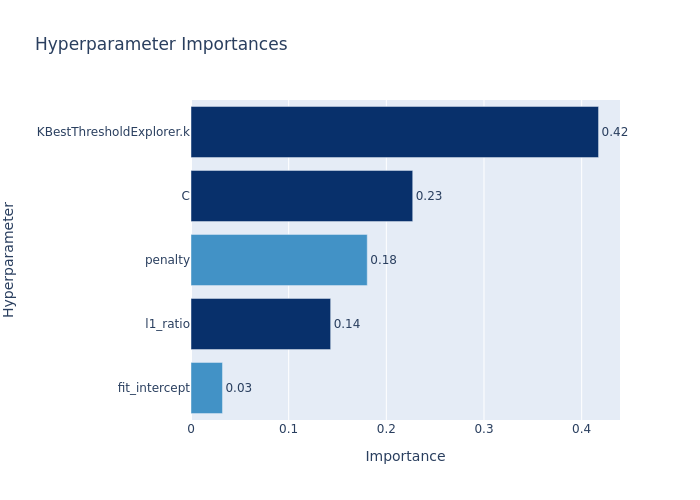

In [24]:
from IPython.display import Image

f = optuna.visualization.plot_param_importances(study)
Image(f.to_image(format="png", engine='kaleido'))

The following is a slice plot to better understand the parameter relationships. We see how the change in the parameter affects the performance of the model.

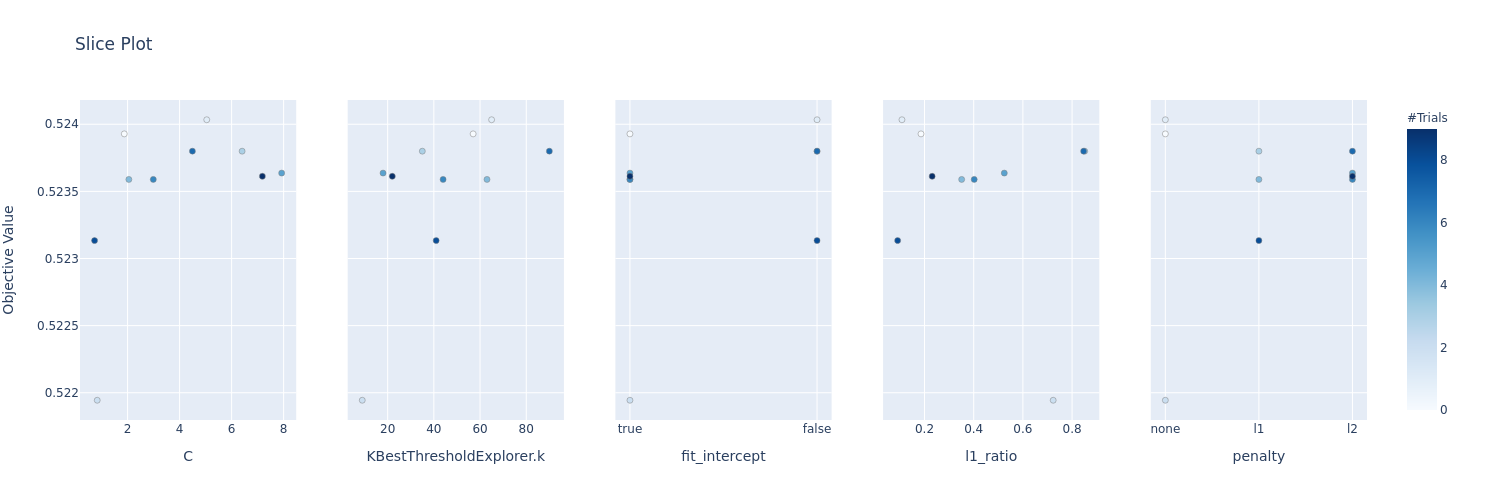

In [25]:
f = optuna.visualization.plot_slice(study, params=['l1_ratio', 'C', 'KBestThresholdExplorer.k', 'penalty', 'fit_intercept'])
Image(f.to_image(format="png", engine='kaleido'))

Let's plot the history of all trials in the study to see how the performance improvements took place within the study

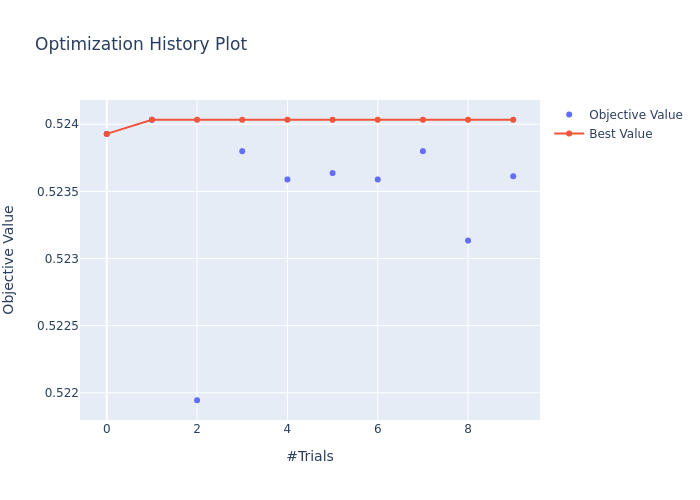

In [26]:
f = optuna.visualization.plot_optimization_history(study)
Image(f.to_image(format="png", engine='kaleido'))